In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

In [2]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.1, img_size=224,Gray2RGB=True)

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 3)
(2686, 15)
(299, 224, 224, 3)
(299, 15)


In [103]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.25))

# model.add(Flatten())

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_70 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
activation_70 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_71 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
activation_71 (Activation)   (None, 112, 112, 128)     0         
__________

In [104]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}_0426.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=16, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 64
aug_ratio = 2
epochs = 400
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint,earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/400
82/83 [============================>.] - ETA: 0s - loss: 2.4543 - acc: 0.2139
Epoch 00001: val_loss improved from inf to 2.88653, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D_0426.h5
83/83 [==============================] - 60s 718ms/step - loss: 2.4502 - acc: 0.2149 - val_loss: 2.8865 - val_acc: 0.0502
Epoch 2/400
82/83 [============================>.] - ETA: 0s - loss: 1.9950 - acc: 0.3839
Epoch 00002: val_loss did not improve from 2.88653
83/83 [==============================] - 41s 499ms/step - loss: 1.9916 - acc: 0.3858 - val_loss: 3.0526 - val_acc: 0.0502
Epoch 3/400
82/83 [============================>.] - ETA: 0s - loss: 1.8077 - acc: 0.4665
Epoch 00003: val_loss did not improve from 2.88653
83/83 [==============================] - 41s 499ms/step - loss: 1.8047 - acc: 0.4676 - val_loss: 3.1058 - val_acc: 0.0468
Epoch 4/400
82/83 [============================>.] - ETA: 0s - loss: 1.7135 - acc: 0.5078
Epoch 00004: val_loss did not improve from 2.8

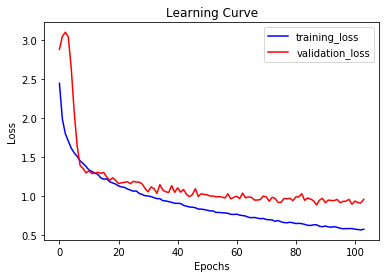

In [108]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, 'b', label="training_loss")
plt.plot(val_loss, 'r', label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

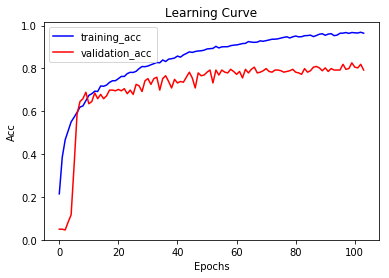

In [109]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, 'b', label="training_acc")
plt.plot(val_acc, 'r', label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [110]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(2686, 224, 224, 3)
(2686, 15)
(299, 224, 224, 3)
(299, 15)


In [111]:
X_test, X_id = load_test_data(Gray2RGB=True)
print(X_test.shape)

(1500, 224, 224, 3)


In [112]:
print(X_valid.shape)

(299, 224, 224, 3)


In [113]:
model_path = './saved_models/{}_0426.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('submissions_0426.csv'.format(model_name), index=False)

299/299 [==============================] - 4s 13ms/step
Validation loss: 0.8909543035022391
Validation accuracy: 0.80936454809629


In [99]:
#X_train

In [ ]:
#X_test

In [ ]:
pp

In [9]:
# a classic CNN model
model_name = 'classic_CNN_GlobalAveragePooling2D'
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_7 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_8 (Activation)    (None, 112, 112, 128)     0         
__________

In [10]:
# Data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0)

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
166/167 [============================>.] - ETA: 0s - loss: 2.5018 - acc: 0.1956
Epoch 00001: val_loss improved from inf to 3.03830, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 15s 89ms/step - loss: 2.5013 - acc: 0.1955 - val_loss: 3.0383 - val_acc: 0.0569
Epoch 2/200
166/167 [============================>.] - ETA: 0s - loss: 2.0136 - acc: 0.3723
Epoch 00002: val_loss did not improve from 3.03830
167/167 [==============================] - 11s 66ms/step - loss: 2.0137 - acc: 0.3712 - val_loss: 3.1039 - val_acc: 0.0569
Epoch 3/200
166/167 [============================>.] - ETA: 0s - loss: 1.8644 - acc: 0.4287
Epoch 00003: val_loss improved from 3.03830 to 2.58687, saving model to ./saved_models/classic_CNN_GlobalAveragePooling2D.h5
167/167 [==============================] - 11s 66ms/step - loss: 1.8619 - acc: 0.4307 - val_loss: 2.5869 - val_acc: 0.1639
Epoch 4/200
166/167 [============================>.] - ETA

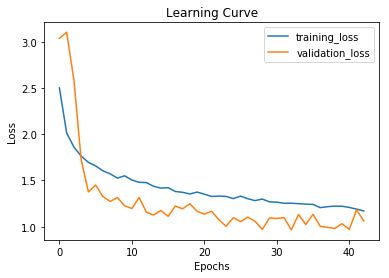

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

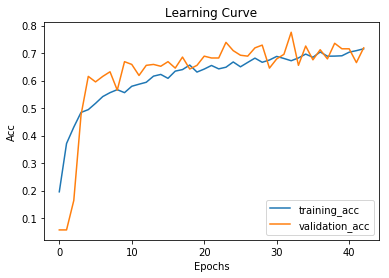

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
X_test, X_id = load_test_data()

model_path = './saved_models/{}.h5'.format(model_name)
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

299/299 [==============================] - 1s 2ms/step
Validation loss: 0.9649896470200656
Validation accuracy: 0.775919732242125
